## How sensitive is ES to systemic coupling?

In [1]:
import numpy as np
import scipy
from scipy.stats import ncx2
from scipy.special import hyp1f1
from scipy.optimize import brentq
from math import exp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kurtosis

DECIMALS = 6

np.set_printoptions(precision=DECIMALS, suppress=True)
pd.options.display.float_format = lambda x: f"{x:.{DECIMALS}f}"
pd.set_option("display.precision", DECIMALS)

In [2]:
def lambda_max_generator(epsilon, y, theta, sigma, kappa, max_attempts=5, tol=1e-8):
    """
    
    Compute H^*_epsilon such that P_y(sigma_H < tau) = G_y(H; H) <= epsilon.
    This function implements Equation (11) using the closed-form in Equation (19).

    """

    def G_y(H):

        a = H / kappa  # Now using H as the Laplace exponent (since tau ~ Exp(H))
        b = 2 * kappa * theta / sigma**2
        z_y = 2 * kappa * y / sigma**2
        z_H = 2 * kappa * H / sigma**2

        num = hyp1f1(a, b, z_y)
        denom = hyp1f1(a, b, z_H)
        
        return num / denom  # This is G_y(H; H) = E[e^{-H * sigma_H}]

    def root_function(H):
        return G_y(H) - epsilon

    # Bracketing interval
    H_min = y + 1e-8
    H_max = y + 10.0

    # Expand H_max until G_y(H_max) < epsilon
    for _ in range(max_attempts):
        try:
          H_star = scipy.optimize.toms748(root_function, H_min, H_max, xtol=tol)
          
          if root_function(H_star)<=0:
            
            return H_star
          
          else:
          
            while root_function(H_star)>0:
              H_star = H_star + 1e-2
          
            return H_star
          
        except Exception:
            pass
        
        H_max += 5.0

    # Fallback: scan manually to find conservative H
    print("[Warning] brentq failed to converge. Using fallback grid search.")
    H_vals = np.linspace(H_min, H_max + 50, 1000)
    for H in H_vals:
        if G_y(H) <= epsilon:
            return H

    raise RuntimeError("Unable to find H^*_epsilon. Try expanding search space.")


In [3]:
def cir_transition_sample_per_sector(y_vec, tau, kappa_vec, theta_vec, sigma_vec, rng):
    """
    y_vec, kappa_vec, theta_vec, sigma_vec are arrays of length J (sectors).
    Returns xi_vec: sampled Y_{t+tau} per sector (length J).
    """
    if tau <= 0:
        return y_vec.copy()
    
    one_minus = -np.expm1(-kappa_vec * tau)  # = 1 - exp(-kappa*tau)
    # avoid zeros
    one_minus = np.where(one_minus <= 0, 1e-16, one_minus)
    
    c = (sigma_vec * sigma_vec * one_minus) / (4.0 * kappa_vec)
    d = 4.0 * kappa_vec * theta_vec / (sigma_vec * sigma_vec)
    
    # noncentrality parameters
    nc = (4.0 * kappa_vec * np.exp(-kappa_vec * tau) * y_vec) / (sigma_vec * sigma_vec * one_minus)
    
    # guard
    d = np.maximum(d, 1e-12)
    nc = np.maximum(nc, 0.0)
    
    # sample per sector (simple looping works fine since J would be typically small)
    xi = np.empty_like(y_vec, dtype=float)

    for j in range(len(y_vec)):
    
        # If df or nc are extreme, ncx2.rvs might throw an error
        try:
            Z = ncx2.rvs(df=d[j], nc=nc[j], random_state=rng)
    
        except Exception:
            Z = ncx2.rvs(df=max(d[j],1e-6), nc=0.0, random_state=rng) + nc[j]
    
        xi[j] = c[j] * Z
    
    xi = np.maximum(xi, 0.0)
    
    return xi


In [4]:
LGD_MEAN = 0.45
LGD_STD = 0.15

def get_beta_params(mu, sigma):
    if sigma**2 >= mu * (1 - mu):
        raise ValueError("Standard deviation is too high for this mean.")

    nu = (mu * (1 - mu) / sigma**2) - 1
    alpha = mu * nu
    beta = (1 - mu) * nu
    return alpha, beta

alpha_lgd, beta_lgd = get_beta_params(LGD_MEAN, LGD_STD)

In [5]:
alpha_lgd, beta_lgd

(4.500000000000001, 5.500000000000002)

In [6]:
from scipy.interpolate import interp1d

def loss_distribution_plot(Payoff_T,index):
  # Get histogram data (without plotting)
  counts, bin_edges = np.histogram(Payoff_T, bins=10, density=True)

  # Get bin centers
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

  # Interpolation function
  f_interp = interp1d(bin_centers, counts, kind='cubic', fill_value="extrapolate")

  # New x-values for smooth curve
  x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 500)
  y_smooth = f_interp(x_smooth)

  # Plot histogram and interpolated curve
  plt.hist(Payoff_T, bins=100, density=True, label='Histogram_'+str(index),alpha = 0.4)
  plt.plot(x_smooth, y_smooth, label='Loss Distribution Case_'+str(index))
  plt.xlabel('Loss')
  plt.ylabel('Density')
  # plt.legend()
  plt.title('Loss Distribution for '+str(index))


In [7]:
def expected_shortfall(losses, alpha=0.95):
    var_alpha = np.quantile(losses, alpha)
    tail_losses = losses[losses >= var_alpha]
    return float(np.round(tail_losses.mean(), DECIMALS))

def compute_metrics(losses, alpha=0.95):
    var_alpha = np.quantile(losses, alpha)
    es = expected_shortfall(losses, alpha)
    metrics = {
        "Mean": np.mean(losses),
        "Std": np.std(losses),
        "VaR": var_alpha,
        "ES": es,
        "Excess ES": es - var_alpha,
        "ExcessKurtosis": kurtosis(losses)
    }
    return {key: float(np.round(value, DECIMALS)) for key, value in metrics.items()}

In [8]:
loan_types = ["bullet", "linear", "french", "negative"]

def bullet_exposure(contract, T, t):
    P = float(contract["P"])
    return P if t < T else 0.0


def linear_exposure(contract, T, t):
    P = float(contract["P"])
    periods_per_year = float(contract["N"])
    if periods_per_year <= 0 or T <= 0:
        return 0.0

    period = 1.0 / periods_per_year  # years per period
    total_periods = int(np.ceil(T * periods_per_year))
    payments_made = int(np.floor(t / period))
    payments_made = int(np.clip(payments_made, 0, total_periods))
    principal_paid = (payments_made / total_periods) * P
    return max(P - principal_paid, 0.0)


def french_exposure(contract, T, t):
    P = float(contract["P"])
    periods_per_year = float(contract["N"])
    r_annual = float(contract["r"])
    if periods_per_year <= 0 or T <= 0:
        return 0.0

    period = 1.0 / periods_per_year  # years per period
    total_periods = int(np.ceil(T * periods_per_year))
    payments_made = int(np.floor(t / period))
    payments_made = int(np.clip(payments_made, 0, total_periods))
    periods_remaining = total_periods - payments_made
    if periods_remaining <= 0:
        return 0.0

    r_period = r_annual / periods_per_year  # annual to per-period rate

    if r_period == 0.0:
        payment = P / total_periods
        return payment * periods_remaining

    annuity_payment = P * r_period / (1.0 - (1.0 + r_period) ** (-total_periods))
    pv_remaining = annuity_payment * (1.0 - (1.0 + r_period) ** (-periods_remaining)) / r_period
    return pv_remaining


def negative_amortization_exposure(contract, T, t):
    P = float(contract["P"])
    periods_per_year = float(contract["N"])
    r_annual = float(contract.get("r", 0.0))
    if periods_per_year <= 0 or T <= 0:
        return max(P, 0.0)

    period = 1.0 / periods_per_year  # years per period
    total_periods = int(np.ceil(T * periods_per_year))
    periods_elapsed = int(np.floor(t / period))
    periods_elapsed = int(np.clip(periods_elapsed, 0, total_periods))

    r_period = r_annual / periods_per_year  # annual to per-period rate

    exposure = P * ((1.0 + r_period) ** periods_elapsed)

    return exposure if t < T else 0.0


def exposure_at_time(contract, T, t):
    loan_type = str(contract["type"]).lower()
    dispatch = {
        "bullet": bullet_exposure,
        "linear": linear_exposure,
        "french": french_exposure,
        "negative_amortisation": negative_amortization_exposure,
    }
    if loan_type not in dispatch:
        raise ValueError(f"Unknown loan type: {loan_type}")
    return dispatch[loan_type](contract, T, t)


In [9]:
def simulate_sector_cir_model(kappa, theta, sigma, T, delta, W, eps, lambda_benchmark,
                              Nfirms, idiosyncratic_factor, loan_contracts, alpha_lgd, beta_lgd, rng=None):

    import warnings

    if rng is None:
        rng = np.random.default_rng()

    # ensure shapes
    J = len(theta)
    assert W.shape == (Nfirms, J)
    idiosyncratic_factor = np.asarray(idiosyncratic_factor).reshape(Nfirms,)
    lambda_benchmark = np.asarray(lambda_benchmark).reshape(J,)

    delta = np.asarray(delta)
    if delta.ndim == 1:
        delta = np.tile(delta.reshape(1, J), (Nfirms, 1))
    assert delta.shape == (Nfirms, J)

    # init
    t = 0.0
    Y_t = theta.copy().astype(float)   # sectoral intensities (J-vector), initialised at theta
    events = []
    owed = []
    marks = []
    defaulter_idio_factor = []
    sector_contributions = []
    alive = np.arange(Nfirms, dtype=int)

    # precompute some arrays for speed
    kappa = np.asarray(kappa, dtype=float)
    sigma = np.asarray(sigma, dtype=float)
    theta = np.asarray(theta, dtype=float)

    # event loop
    while (t < T) and (alive.size > 0):

        lambda_max = np.maximum(Y_t, lambda_benchmark)  # J-vector
        # Hepsilon = sum_i [ X_i + w_i · lambda_max ] over alive firms
        
        # We can compute per-firm value and sum
        per_firm_sys = W[alive].dot(lambda_max)   # length alive.size
        per_firm_idio = idiosyncratic_factor[alive]
        Hepsilon = per_firm_sys.sum() + per_firm_idio.sum()

        if Hepsilon <= 0:
            break

        # sample a candidate waiting time
        tau = rng.exponential(1.0 / Hepsilon)
        t_candidate = t + tau
        if t_candidate >= T:
            break

        # sample sectoral Y at t_candidate conditional on no defaults in the waiting time
        Y_proposed = cir_transition_sample_per_sector(Y_t, tau, kappa, theta, sigma, rng)

        # compute proposed per-firm intensities (scalar values) using Y_proposed
        per_firm_sys_prop = W[alive].dot(Y_proposed)
        per_firm_total_prop = per_firm_sys_prop + per_firm_idio
        lambda_proposed_total = per_firm_total_prop.sum()

        # acceptance probability: Xi / Hepsilon where Xi = lambda_proposed_total
        accept_prob = min(lambda_proposed_total / Hepsilon, 1.0)
        if rng.random() < accept_prob:
            # accept a default at t_candidate
            t = t_candidate
            events.append(t)

            # choose which alive firm defaulted
            probs = per_firm_total_prop / lambda_proposed_total
            probs = np.maximum(probs, 0.0)
            probs = probs / probs.sum()
            selected_local_idx = rng.choice(len(alive), p=probs)
            selected_firm = int(alive[selected_local_idx])

            # record idiosyncratic factor
            defaulter_idio_factor.append(float(idiosyncratic_factor[selected_firm]))

            sector_contributions.append(W[selected_firm].copy())

            # mark (loss) from contract exposure
            contract = loan_contracts[selected_firm]
            exposure = exposure_at_time(contract, T, t)
            if exposure < 0:
                warnings.warn("Exposure computed negative; clamping to zero.")
                exposure = max(exposure, 0.0)
            if t >= T and exposure > 0:
                warnings.warn("Exposure positive after maturity; forcing to zero.")
                exposure = 0.0

            owed.append(exposure)
            
            LGD = rng.beta(alpha_lgd, beta_lgd)
            mark = LGD * exposure
            # mark =  exposure
            if mark < 0:
                warnings.warn("Loss mark negative; clamping to zero.")
                mark = max(mark, 0.0)
            marks.append(mark)

            # update Y_t with contagion
            Y_t = Y_proposed + delta[selected_firm] * mark/contract["P"]

            # remove defaulted firm from alive set
            alive = np.delete(alive, selected_local_idx)

        else:
            # reject, ie no default: advance time and set Y_t = Y_proposed
            t = t_candidate
            Y_t = Y_proposed

    return (np.array(events), np.array(marks), np.array(owed),
            np.array(defaulter_idio_factor), np.array(sector_contributions))

In [10]:
def generate_portfolio_weights(N, J, composition_type, concentration_params=None, rng=None):
    """
    Build portfolio weights under three stylised configurations plus a random fallback.

    - concentrated: one dominant sector for every obligor (eg for J=3 [0.7, 0.2, 0.1])
    - balanced: evenly distributed across sectors (eg for J=3  [1/3, 1/3, 1/3])
    - mixed: partial concentration with residual diversified weights (eg for J=3  [0.5, 0.3, 0.2])
    - random: symmetric Dirichlet for variation.
    """
    if rng is None:
        rng = np.random.default_rng()

    if concentration_params is None:
        concentration_params = {}

    noise_level = concentration_params.get("noise_level", 0.0)
    alpha_random = concentration_params.get("alpha", 1.0)

    if composition_type == "concentrated":
        pattern = _pattern_concentrated(J)
        W = _apply_noise_and_normalize(pattern, N, noise_level, rng)
    elif composition_type == "balanced":
        pattern = _pattern_balanced(J)
        W = _apply_noise_and_normalize(pattern, N, noise_level, rng)
    elif composition_type == "mixed":
        pattern = _pattern_mixed(J)
        W = _apply_noise_and_normalize(pattern, N, noise_level, rng)
    elif composition_type == "random":
        W = _generate_random_weights(N, J, {"alpha": alpha_random}, rng)
    else:
        raise ValueError(f"Unknown composition_type: {composition_type}")

    return W


def _pattern_concentrated(J, dominant=0.7):
    if J <= 0:
        return np.array([])
    if J == 1:
        return np.array([1.0])
    residual = max(1.0 - dominant, 0.0)
    tail = residual / (J - 1)
    vec = np.full(J, tail)
    vec[0] = dominant
    return vec


def _pattern_balanced(J):
    if J <= 0:
        return np.array([])
    return np.full(J, 1.0 / J)


def _pattern_mixed(J, primary=0.5, secondary=0.3):
    if J <= 0:
        return np.array([])
    vec = np.zeros(J)
    vec[0] = min(primary, 1.0)
    if J >= 2:
        vec[1] = min(secondary, max(1.0 - vec[0], 0.0))
    residual = max(1.0 - vec.sum(), 0.0)
    if J > 2:
        vec[2:] = residual / (J - 2)
    elif J == 1:
        vec[0] = 1.0
    else:
        vec[1] += residual
    return vec


def _apply_noise_and_normalize(pattern, N, noise_level, rng):
    base = np.tile(pattern, (N, 1))
    if noise_level > 0:
        noise = rng.normal(0.0, noise_level, size=base.shape)
        base = base + noise
    base = np.maximum(base, 1e-6)
    base = base / base.sum(axis=1, keepdims=True)
    return base


def _generate_random_weights(N, J, params, rng):
    alpha = params.get("alpha", 1.0)
    W = np.zeros((N, J))
    for i in range(N):
        W[i] = rng.dirichlet(np.full(J, alpha))
    return W

In [11]:
def run_simulation(params, loan_contracts, num_trials, seed=42):

    rng = np.random.default_rng(seed)
    eps = 1e-5
    losses = np.zeros(num_trials)
    for i in range(num_trials):
        events, marks, _, _, _ = simulate_sector_cir_model(params['kappa'], params['theta'], params['sigma'], 
                          params['T'], params['delta'], params['W'], 1e-5, 
                          params['lambda_benchmark'], 
                          params['Firms'], params['idio_factor'], 
                          loan_contracts, alpha_lgd, beta_lgd,
                          rng)
        losses[i] = np.sum(marks)
    return losses

In [12]:
def compute_ES_c_curve_with_CI(
    params,
    loan_contracts,
    c_values,
    num_trials=4000,
    alpha=0.95,
    seed=42,
    num_batches=10
):
    """
    Computes mean ES(c) with simple Monte Carlo error bars
    using batching.

    """
    rng = np.random.default_rng(seed)
    batch_size = num_trials // num_batches
    ES_mean = []
    ES_std = []

    for c in c_values:
        params_c = params.copy()
        params_c["delta"] = c * params["delta"]

        ES_batches = []

        for b in range(num_batches):
            losses = run_simulation(
                params_c,
                loan_contracts,
                num_trials=batch_size,
                seed=rng.integers(1e9)
            )
            ES_batches.append(expected_shortfall(losses, alpha))

        ES_mean.append(np.mean(ES_batches))
        ES_std.append(np.std(ES_batches))

    return np.array(ES_mean), np.array(ES_std)

In [13]:
def plot_ES_c_curves(
    c_values,
    ES_dict,
    ES_std_dict=None
):
    """
    ES_dict: {label: ES_values}
    ES_std_dict (optional): {label: std_values}
    """

    plt.figure(figsize=(7, 4.5))

    for label, ES_vals in ES_dict.items():
        plt.plot(c_values, ES_vals, marker="o", label=label)

        if ES_std_dict is not None:
            std = ES_std_dict[label]
            plt.fill_between(
                c_values,
                ES_vals - std,
                ES_vals + std,
                alpha=0.2
            )

    plt.xlabel("Contagion Coupling Strength $c$")
    plt.ylabel("Expected Shortfall (95%)")
    plt.title("Tail Risk Sensitivity to Systemic Coupling")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Balanced sectors

In [14]:
rng = np.random.default_rng(1265883927568217)

N_firms = 1000
J = 3

c = 0.01

T = 2

NUM_TRIALS = 2500

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "balanced", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [3.637663 4.700201 5.508869]


In [15]:
bullet_contracts = [
    {
        "type": "bullet", 
        "P": 10, 
        "N": 12, 
        "r": 0.12
    } 
    for i in range(N_firms)
]


linear_contracts = [{
    "type": "linear", 
    "P": 10, 
    "N": 12, 
    "r": 0.12
} for i in range(N_firms)]

french_contracts = [{
    "type": "french", 
    "P": 10, 
    "N": 12, 
    "r": 0.12
} for i in range(N_firms)]


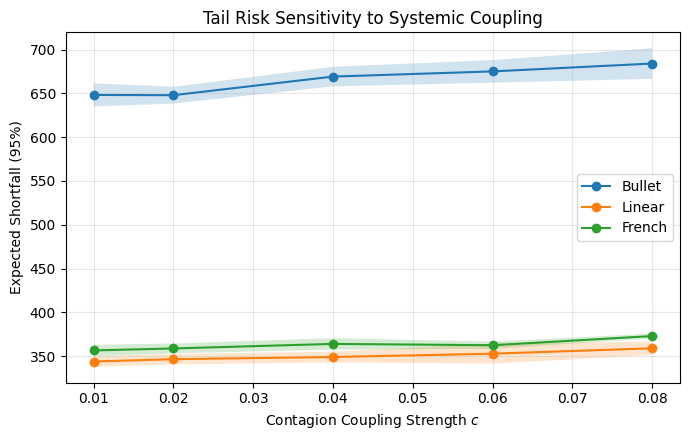

In [16]:
ES_mean = {}
ES_std = {}

c_vals = np.array([0.01, 0.02, 0.04, 0.06, 0.08])

for label, contracts in {
    "Bullet": bullet_contracts, 
    "Linear": linear_contracts, 
    "French": french_contracts
}.items():

    m, s = compute_ES_c_curve_with_CI(
        params,
        contracts,
        c_vals,
        num_trials=2500
    )
    ES_mean[label] = m
    ES_std[label] = s

plot_ES_c_curves(c_vals, ES_mean, ES_std)

## Concentrated sectoral regime

In [17]:
rng = np.random.default_rng(1265883927568217)

N_firms = 1000
J = 3

c = 0.01

T = 2

NUM_TRIALS = 2500

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "concentrated", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [3.637663 4.700201 5.508869]


In [18]:
bullet_contracts = [
    {
        "type": "bullet", 
        "P": 10, 
        "N": 12, 
        "r": 0.12
    } 
    for i in range(N_firms)
]


linear_contracts = [{
    "type": "linear", 
    "P": 10, 
    "N": 12, 
    "r": 0.12
} for i in range(N_firms)]

french_contracts = [{
    "type": "french", 
    "P": 10, 
    "N": 12, 
    "r": 0.12
} for i in range(N_firms)]


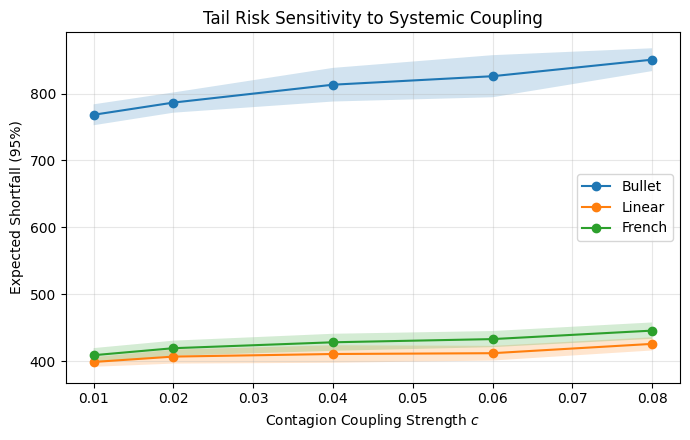

In [19]:
ES_mean_c = {}
ES_std_c = {}

c_vals = np.array([0.01, 0.02, 0.04, 0.06, 0.08])

for label, contracts in {
    "Bullet": bullet_contracts, 
    "Linear": linear_contracts, 
    "French": french_contracts
}.items():

    m, s = compute_ES_c_curve_with_CI(
        params,
        contracts,
        c_vals,
        num_trials=2500
    )
    ES_mean_c[label] = m
    ES_std_c[label] = s

plot_ES_c_curves(c_vals, ES_mean_c, ES_std_c)